# Analysis of Weather Down Under
by Charles Fechtig

### Introduction:  
Global warming is a top issue in contemporary political discourse. In this tutorial I use an Australian dataset containing daily weather observations to determine if the average temperature increased over the years 2007 – 2017. This is especially relevant given the terrible wildfires that tore through Australia in early 2020. The first question I ask is this: Did Australia’s average yearly temperature increase over the years 2007 – 2017? My first hypothesis is this: A positive correlation exists between year and average temperature per year in Australia over the years 2007 – 2017. Next, I will use the same dataset to generate a model to predict if it will rain tomorrow based on weather observations from today. Meteorologists use sophisticated computational models to produce accurate weather forecasts, and I attempted to do the same here. The second question I ask is this: Can a multiple logistic regression model accurately predict if it will rain tomorrow based on wind speed, humidity, atmospheric pressure, cloud coverage, and temperature today. My second hypothesis is this: Whether or not it will rain tomorrow can be predicted from the variables WindSpeed, Humidity, Pressure, Cloud, and Temp (all 3pm) using multiple logistic regression. Finally, I will make a cool map showing average rainfall in the various locations of the dataset.


## Part 0 - Importing Required Libraries
- pandas allows us to create and manipulate a dataframe object
- scipy for statistical analysis
- statsmodel for statistical formulas (similar to R's syntax)
- sklearn for logistic regression model
- seaborn for nice plots
- folium and geopy for maps

In [1]:
# general stuff
import pandas as pd
import numpy as np
import re
# analysis stuff
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# plot stuff
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)
# map stuff
import folium
from geopy.geocoders import Nominatim

## Part 1 - Data Formatting
### The Dataset:  
The dataset used was compiled by kaggle user Joe Young, who acquired the base data from the Australian government (http://www.bom.gov.au/climate/data). The dataset can be found at https://www.kaggle.com/jsphyg/weather-dataset-rattle-package. The base dataset contains 19 variables, namely Date, Location, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, Temp3pm, RainToday, and RainTomorrow. The base dataset contains 145,460 entries.

In [2]:
# reading in csv file aquired from https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
print(df.info())
print()
print("Amount of missing data per variable:\n" + str(df.isna().sum()))
# notice the large amount of missing data in Evaporation and Sunshine columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Missing Data:
Here, I opted to just remove missing data instead of imputing. I first dropped columns with lots of missing data, then dropped rows with missing data. 71045 entires are left remaining after these steps.
### Formatting Data:
I converted the Date variable of the dataset into pandas datetime objects, then created a Year column. Next, I changed the dichotomous outcome variables from 'Yes' and 'No' to numeric 1 and 0.

In [4]:
dfr = df.copy()                                                         # creating copy of dataset to be reduced

dfr.drop(['Evaporation', 'Sunshine'], axis=1, inplace=True)             # removing coloumns with a lot of missing values

dfr.dropna(inplace=True)                                                # removing rows with missing values

dfr['Date'] = pd.to_datetime(dfr['Date'])                               # converting 'Date' column into datetime object

dfr['Year'] = dfr['Date'].dt.year                                       # creating 'Year' column from 'Date

dfr['RainToday'] = (dfr['RainToday']=='Yes').astype(int)                # converting 'RainToday' to numeric (0 or 1)
dfr['RainTomorrow'] = (dfr['RainTomorrow']=='Yes').astype(int)          # converting 'RainTomorrow' to numeric (0 or 1)

dfr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71045 entries, 4 to 145458
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           71045 non-null  datetime64[ns]
 1   Location       71045 non-null  object        
 2   MinTemp        71045 non-null  float64       
 3   MaxTemp        71045 non-null  float64       
 4   Rainfall       71045 non-null  float64       
 5   WindGustDir    71045 non-null  object        
 6   WindGustSpeed  71045 non-null  float64       
 7   WindDir9am     71045 non-null  object        
 8   WindDir3pm     71045 non-null  object        
 9   WindSpeed9am   71045 non-null  float64       
 10  WindSpeed3pm   71045 non-null  float64       
 11  Humidity9am    71045 non-null  float64       
 12  Humidity3pm    71045 non-null  float64       
 13  Pressure9am    71045 non-null  float64       
 14  Pressure3pm    71045 non-null  float64       
 15  Cloud9am       710

In [5]:
dfr.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,2008
11,2008-12-12,Albury,15.9,21.7,2.2,NNE,31.0,NE,ENE,15.0,...,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0,1,1,2008
12,2008-12-13,Albury,15.9,18.6,15.6,W,61.0,NNW,NNW,28.0,...,93.0,994.3,993.0,8.0,8.0,17.4,15.8,1,1,2008
16,2008-12-17,Albury,14.1,20.9,0.0,ENE,22.0,SSW,E,11.0,...,82.0,1012.2,1010.4,8.0,1.0,17.2,18.1,0,1,2008
17,2008-12-18,Albury,13.5,22.9,16.8,W,63.0,N,WNW,6.0,...,65.0,1005.8,1002.2,8.0,1.0,18.0,21.5,1,1,2008


## Part 2 - Data Analysis
- First, find if correlation between date and temperature exists
- Second, run logistic regression to predict if it will rain next day

### A) Correlation between year and average temperature for that year:
The first analysis run is a Pearson’s R correlation test via the stats package in scipy. Correlation tests determine whether or not there is a relationship between two variables, the direction of the relationship, and the strength of the relationship. The ‘r’ value given by Pearson’s R gives the direction off the relationship by its sign (+/-) and the strength of the relationship by its magnitude (closeness to +1/-1 or 0). The two variables being considered are year and average daily minimum temperature per year. The same correlation test is performed on both average daily minimum daily temperature per year and average maximum daily temperature per year. To generate the input data, an averaging function is applied on the dataset grouped by year.

In [6]:
yearly_av = dfr.groupby('Year').mean().reset_index()

In [7]:
min_temp_pearson = stats.pearsonr(yearly_av['Year'], yearly_av['MinTemp'])
print("MinTemp vs Year")
print("Pearson's r:", min_temp_pearson[0])
print("p-value:", min_temp_pearson[1])

MinTemp vs Year
Pearson's r: 0.8212981240357
p-value: 0.0019364626180743661


In [8]:
max_temp_pearson = stats.pearsonr(yearly_av['Year'], yearly_av['MaxTemp'])
print("MaxTemp vs Year")
print("Pearson's r:", max_temp_pearson[0])
print("p-value:", max_temp_pearson[1])

MaxTemp vs Year
Pearson's r: 0.10134364248550007
p-value: 0.7668562875533013


### Correlation Assumptions:
Pearson’s R assumes linearity, normality, homogeneity of variance, and continuous/interval level data. A linear relationship between year and average daily min temp seems apparent. Min temp does in fact show a normal distribution. Variance of min temp across all years except 2007 seems homogeneous, and this may be due to a lack of data from some locations in 2007. No correlation exist between year and average daily max temp. We will consider only MinTemp vs Year as MaxTemp vs Year shows no significant correlation.

<AxesSubplot:xlabel='Year', ylabel='MinTemp'>

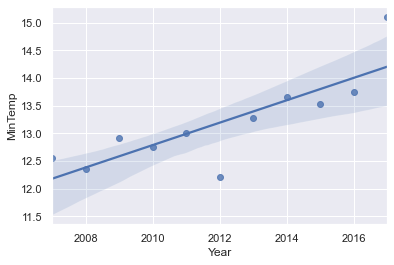

In [9]:
# checking linearity
sns.regplot(x='Year', y='MinTemp', data=yearly_av)

<AxesSubplot:xlabel='MinTemp', ylabel='Count'>

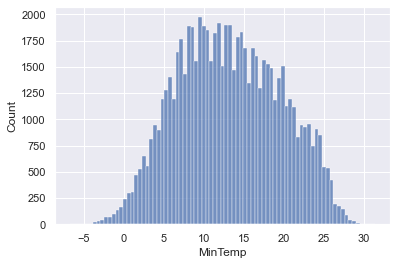

In [10]:
# checking normality
sns.histplot(x='MinTemp', data=dfr)

<AxesSubplot:xlabel='Year', ylabel='MinTemp'>

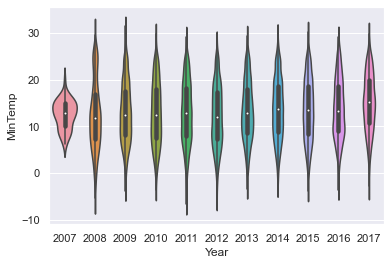

In [11]:
# checking homoscedascity
sns.violinplot(x='Year', y='MinTemp', data=dfr)

### Correlation Results:
The Pearson’s R correlation test concerned with the relationship between year and average yearly min temperature garnered significant results. There is a strong positive correlation between year and average yearly min temperature; r = 0.821, p = 0.002. The r value’s closeness to positive 1 suggests a strong positive correlation, while the small p values indicates the significance of these results. No significant relationship was found between year and average yearly max temperature; r = 0.101, p = 0.767. These results suggest that daily minimum temperatures increased over the years 2007 to 2017, while daily maximum temperatures neither increased nor decreased over those same years.

### B) Logistic regression to predict if it will rain tomorrow ('RainTomorrow') based on wind speed, humidity, pressure, cloud coverage, and temperature:
The second analysis run is a multiple logistic regression via the statsmodels.api package, as well as sklearn’s Logistic Regression package. I use statsmodel.api to attain an in depth summary of the logistic regression model and every relevent variable within it. I use sklearn to demonstrate a more classic machine learning pipeline. Logistic regression is much like linear regression, except it is used when the outcome variable is binary (dichotomous). While linear regression models are given in the form y=mx+b, logistic regression models are sigmoidal, or ‘S’ shaped.

In [12]:
# create model
mod = smf.logit(formula='RainTomorrow ~ WindSpeed3pm + Humidity3pm + Pressure3pm + Cloud3pm + Temp3pm', data=dfr)
# train model
res = mod.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.374058
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           RainTomorrow   No. Observations:                71045
Model:                          Logit   Df Residuals:                    71039
Method:                           MLE   Df Model:                            5
Date:                Mon, 17 May 2021   Pseudo R-squ.:                  0.3151
Time:                        15:43:10   Log-Likelihood:                -26575.
converged:                       True   LL-Null:                       -38802.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       95.0630      1.897     50.099      0.000      91.344      98.782
WindSpeed3pm     0.0144

### sklearn Logistic Regression
56836 randomly selected entries were given as input to train the sklearn model. The entries were reduced to length 5 vectors containing standardized values of WindSpeed3pm, Humidity3pm, Pressure3pm, Cloud3pm, and Temp3pm. The dichotomous variable to be predicted from one of these vectors is RainTomorrow; 1 indicating that it rains on the subsequent day, and 0 indicating that it does not.

In [13]:
# aquiring data
x = dfr[['WindSpeed3pm', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'Temp3pm']].to_numpy()
y = dfr['RainTomorrow'].to_numpy()

# splitting data into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# standardizing data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# sanity checks
print(x.shape)
print(y.shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(71045, 5)
(71045,)
(56836, 5)
(56836,)
(14209, 5)
(14209,)


In [14]:
# create model
model = LogisticRegression(solver='liblinear', C=0.05, multi_class='ovr', random_state=0)
# train model
model.fit(x_train, y_train)

LogisticRegression(C=0.05, multi_class='ovr', random_state=0,
                   solver='liblinear')

In [15]:
# test model efficacy
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))


y_pred = model.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

0.8355267788021676
0.8365824477443874
[[10151   648]
 [ 1674  1736]]


<AxesSubplot:>

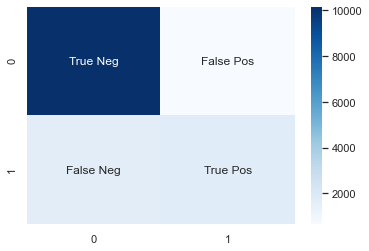

In [16]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

<AxesSubplot:>

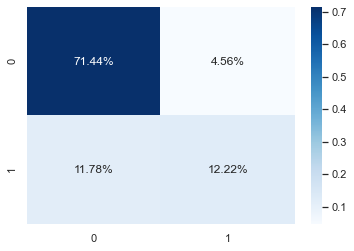

In [17]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

### Logistic Regression Assumptions:
Multiple logistic regression assumes homogeneity of residuals, normality of residuals, dichotomous level outcome data, and no multicollinearity. Humidity and cloud coverage/humidity and temperature seem to have some cross correlation, but this is not significant enough to break the assumption of no multicollinearity. 

In [18]:
# checking multicollinearity
dfr[['WindSpeed3pm', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'Temp3pm']].corr()

,WindSpeed3pm,Humidity3pm,Pressure3pm,Cloud3pm,Temp3pm
WindSpeed3pm,1.000000,0.042798,-0.243780,0.041947,-0.031762
Humidity3pm,0.042798,1.000000,0.024017,0.533923,-0.531156
Pressure3pm,-0.243780,0.024017,1.000000,-0.092761,-0.402999
Cloud3pm,0.041947,0.533923,-0.092761,1.000000,-0.324011
Temp3pm,-0.031762,-0.531156,-0.402999,-0.324011,1.000000


### Logistic Regression Results:
First, a logistic regression was run via the statsmodel.api package. This method does not automatically split the data into a train and test set, rather, it generates the model based on all the input data and assesses the efficacy of the model with that same data. Training and testing a model on the same data can result in overfitting. The resulting model showed P-values of < 0.001 for all input variables. As wind speed, humidity, and cloud coverage increase, probability of rain tomorrow also increases. As pressure and temperature increase, probability of rain tomorrow decreases.

A separate model was trained on 80% of the dataset using sklearn’s Logistic Regression package. The remaining 20% of the data was used to test the model. The confusion matrix tells us that the model correctly predicted that it would not rain 10151 times, correctly predicted that it would rain 1736 times, incorrectly predicted that it would not rain 648 times, and incorrectly predicted that it would rain 1674 times. The model does not seem to be over fit, as accuracy scores for both the train and test set are similar (~84%). The model is is decent at predicting if it will rain the next day, but could be greatly improved, as indicated by the confusion matrix.

## Part 3 - Maps
This part is just for fun, but it is still good to know geographic mapping functionality. The package used to generate the map is called folium (see documantation here https://python-visualization.github.io/folium/index.html). Another package, geopy, is used to derive latitude and longitude from the location names given in the original dataset.

In [19]:
# function to attain address from camelcase locations given in dataset
def LocationToAddress(s):
    return ' '.join((re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', s))) + ', Australia'

# creating geopy Nominatim object
geolocator = Nominatim(user_agent="geo_agent")
# function to attain latitude and longitude from address
def LatLong(addr):
    location = geolocator.geocode(addr)
    return [location.latitude, location.longitude]
      
loc_addr = [LocationToAddress(x) for x in sorted(dfr['Location'].unique())]
loc_coor = [LatLong(x) for x in loc_addr]

# creating Dataframe for map
map_data = {
    'Location': sorted(dfr['Location'].unique()), 
    'Lat': [row[0] for row in loc_coor], 
    'Lon': [row[1] for row in loc_coor]
}
map_df = pd.DataFrame(data = map_data)

In [20]:
# adding relevent data to Dataframe, specifically average values per location
location_av = dfr.groupby('Location').mean().reset_index()

map_df['MinTemp'] = location_av['MinTemp'].round(2)
map_df['MaxTemp'] = location_av['MaxTemp'].round(2)
map_df['Rainfall'] = location_av['Rainfall'].round(2)

map_df

,Location,Lat,Lon,MinTemp,MaxTemp,Rainfall
0,Albury,-36.080477,146.916280,9.83,18.77,4.65
1,AliceSprings,-23.698388,133.881289,13.96,29.61,1.01
2,Ballarat,-37.562263,143.860722,6.97,15.42,2.56
3,Bendigo,-36.758877,144.282593,8.83,20.42,2.41
4,Brisbane,-27.468968,153.023499,16.41,26.46,3.05
5,Cairns,-16.920666,145.772185,21.20,29.49,6.02
6,Canberra,-35.297591,149.101268,8.01,19.99,2.59
7,Cobar,-31.498333,145.834444,13.17,25.67,1.23
8,CoffsHarbour,-30.296241,153.113529,14.73,23.75,5.73
9,Darwin,-12.460440,130.841047,23.18,32.54,5.03


In [21]:
# creating the map
aus_map = folium.Map(location=[-28, 135], zoom_start=5)

# function to get color form rainfall value: the more blue the more rain, black is no rain... very basic but works
def color_from_rain(r):
    return '#%02x%02x%02x' % (0, 0, int(r*26))

# adding cicle markers to map
for loc, lat, lon, min_temp, max_temp, rainfall in zip(map_df['Location'], map_df['Lat'], map_df['Lon'], map_df['MinTemp'], map_df['MaxTemp'], map_df['Rainfall']):
    folium.CircleMarker(
        [lat, lon],
        popup = (str(loc) + '<br>'
                 'Average MinTemp: ' + str(min_temp) + '<br>'
                 'Average MaxTemp: ' + str(max_temp) + '<br>'
                 'Average Rainfall: ' + str(rainfall) + '<br>'
                ),
        color='b',
        fill_color=color_from_rain(rainfall),
        fill=True,
        fill_opacity=0.7
    ).add_to(aus_map)

aus_map